# Report 3

### by Kaitlyn Keil and Kevin Zhang
### April 2017

<a href = http://tna.europarchive.org/20110116113217/http:/www.food.gov.uk/science/dietarysurveys/dietsurveys/>UK Nutrient Databank</a>

<a href = http://tna.europarchive.org/20110116113217/http://www.food.gov.uk/multimedia/pdfs/cofuserdoc.pdf>User Documentation</a>

In [26]:
""" This file contains code used to analyze the
UK Food Nutrient Databank, the information for which can be found
at the above links.

The following packages are required to run this code.
"""

from __future__ import print_function, division
import pandas as pd

import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
%matplotlib inline
import seaborn as sns

from collections import defaultdict, Counter
import statsmodels.formula.api as smf

In [44]:
def ReadProximates():
    """ Reads the correct sheet from the Excel Spreadsheet downloaded from the databank.
    Cleans the macronutrient data and replaces non-numerical entries with 0.
    
    Returns: cleaned DataFrame
    """
    df = pd.read_excel('dietary.xls', sheetname='Proximates')
    column_list = ['Water (g)', 'Protein (g)', 'Fat (g)', 'Carbohydrate (g)', 'Total sugars (g)']
    
    df['Protein'] = pd.to_numeric(df['Protein (g)'], errors='coerce')
    df['Fat'] = pd.to_numeric(df['Fat (g)'], errors='coerce')
    df['Carbohydrate'] = pd.to_numeric(df['Carbohydrate (g)'], errors='coerce')
    df['Sugars'] = pd.to_numeric(df['Total sugars (g)'], errors='coerce')
    
    df['Protein'].replace([np.nan], 0, inplace=True)
    df['Fat'].replace([np.nan], 0, inplace=True)
    df['Carbohydrate'].replace([np.nan], 0, inplace=True)
    df['Sugars'].replace([np.nan], 0, inplace=True)
        
    return df

In [45]:
tester = ReadProximates()

In [46]:
# Plot clusters on a 2D log scale for first-glance. They do not appear to be particularly differentiated.
# Log coordinates are better for visualization in this instance.

x_vals = 'Protein'
y_vals = 'Carbohydrate'
z_vals = 'Fat'

food_group_dict = {'A':['Cereals','peru'], 'B':['Dairy','beige'], 'C':['Egg','paleturquoise'],
                  'D':['Vegetable','darkolivegreen'], 'F':['Fruit','firebrick'], 'G':['Nuts','saddlebrown'],
                  'J':['Fish','slategray'],'M':['Meat','indianred'], 'O':['Fat','khaki']}

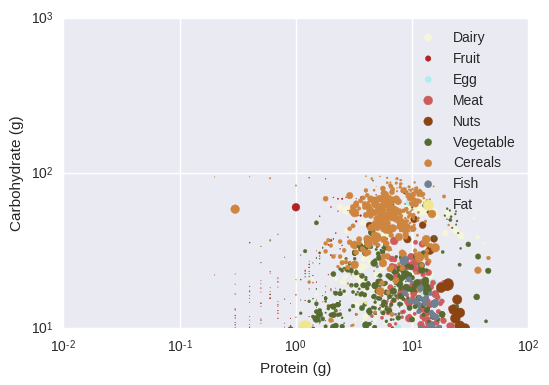

In [47]:
ax = plt.subplot(111)
for key,val in food_group_dict.items():
    df = tester[tester.Group.str.startswith(key, na=False)]
    ax.scatter(df[x_vals],df[y_vals],df[z_vals],color=val[1],label = val[0])
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel(x_vals+' (g)')  
ax.set_ylabel(y_vals+' (g)')
ax.legend()

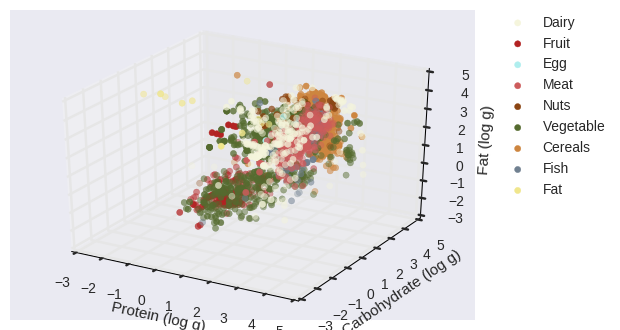

In [48]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
#ax.scatter3D(tester[x_vals], tester[y_vals], tester[z_vals])

for key,val in food_group_dict.items():
    df = tester[tester.Group.str.startswith(key, na=False)]
    ax.scatter3D(np.log(df[x_vals]),np.log(df[y_vals]),np.log(df[z_vals]),color=val[1],label = val[0])
#plt.xscale('log')
#plt.yscale('log')
ax.set_xlabel(x_vals+' (log g)')  
ax.set_ylabel(y_vals+' (log g)')
ax.set_zlabel(z_vals+' (log g)')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [49]:
def ThreeDPlot(pred_cat, actual_cat, ax, actual_label, colors = ['firebrick', 'peru']):
    """ Creates a 3D log log plot on the requested subplot.
    Arguments: 
    pred_cat = predicted dataframe for a category
    actual_cat = dataframe of the real category
    ax = plt axis instance
    actual_label = string with label for the actual category
    colors = list with two entries of strings for color names
    """
    ax.scatter3D(np.log(pred_cat.Protein),np.log(pred_cat.Carbs), np.log(pred_cat.Fat), c = colors[0], label = 'Predicted Group')
    ax.scatter3D(np.log(actual_cat.Protein),np.log(actual_cat.Carbohydrate), np.log(actual_cat.Fat), c = colors[1], label = actual_label, alpha= .5)
    ax.view_init(elev=10, azim=45)
    
    ax.set_xlabel('Protein (log g)')
    ax.set_ylabel('Carbohydrate (log g)')
    ax.set_zlabel('Fat (log g)')
    plt.legend()

In [51]:
#  Create the categories for the different food pyramid groups.
#   Labels were assigned by attempting to find the best match
#   with the generated groups.



# 0 is protein
# 1 is low everything
# 2 is high carb, low sugar
# 3 is high carb, high sugar
# 4 is high fat
# 5 is medium everything

cereals = tester[tester.Group.str.startswith('A', na=False)]
cereals['Label'] = cereals.Protein*0+2

fruits = tester[tester.Group.str.startswith('F', na=False)]
fruits['Label'] = fruits.Protein*0+3

veggies = tester[tester.Group.str.startswith('D', na=False)]
veggies['Label'] = veggies.Protein*0+1

dairy = tester[tester.Group.str.startswith('B', na=False)]
dairy['Label'] = dairy.Protein*0+5

oils = tester[tester.Group.str.startswith('O', na=False)]
oils['Label'] = oils.Protein*0+4

m1 = tester[tester.Group.str.startswith('J', na=False)]
m2 = tester[tester.Group.str.startswith('M', na=False)]
meats = pd.concat([m1,m2])
meats['Label'] = meats.Protein*0

# Create a dataframe using only these categories (drops nuts, eggs, soups/misc, etc)
all_these = pd.concat([cereals, fruits, veggies, dairy, oils, meats])


/home/kaitlyn/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kaitlyn/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kaitlyn/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [53]:
from sklearn.cluster import KMeans

# Selects the appropriate macronutrient columns to feed to the kmeans algorithm
protein = pd.Series(all_these.Protein, name='Protein')
fat = pd.Series(all_these.Fat, name='Fat')
carbs = pd.Series(all_these.Carbohydrate, name='Carbs')
sugars = pd.Series(all_these['Sugars'], name='Sugars')

# Create a new DataFrame using only the macronutrient columns
X = pd.concat([protein,fat,carbs,sugars], axis=1)
X.fillna(0)
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X.dropna())
y_kmeans = kmeans.predict(X)

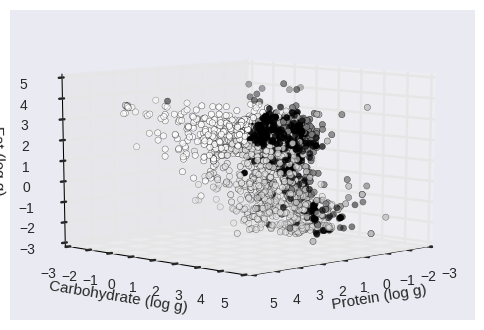

In [54]:
# Created clusters from the kmeans algorithm

ax = plt.subplot(projection='3d')

ax.scatter3D(np.log(X.Protein),np.log(X.Carbs), np.log(X.Fat), c = y_kmeans)
ax.view_init(elev=10, azim=45)
    
ax.set_xlabel('Protein (log g)')
ax.set_ylabel('Carbohydrate (log g)')
ax.set_zlabel('Fat (log g)')

In [55]:
# Create a way to select the categories

predicted_labels = pd.DataFrame(y_kmeans, index=X.index).astype(float)
X['predictions'] = predicted_labels

In [56]:
# Separate out the categories for individual analysis

labeled0 = X[X.predictions == 0]
labeled1 = X[X.predictions == 1]
labeled2 = X[X.predictions == 2]
labeled3 = X[X.predictions == 3]
labeled4 = X[X.predictions == 4]
labeled5 = X[X.predictions == 5]

Following are two examples, plotted on the 3d log scale. For the rest of the comparisons, see the bottom of the journal.

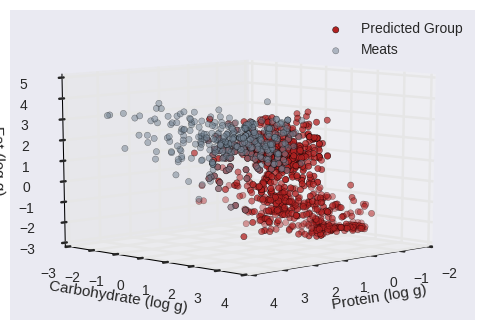

In [57]:
ax = plt.subplot(projection='3d')
ThreeDPlot(labeled1, meats, ax, 'Meats', ['firebrick','slategray'])

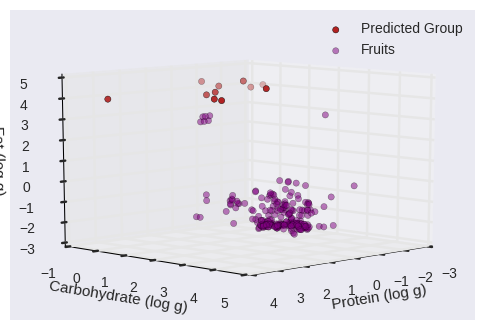

In [58]:
ax = plt.subplot(projection='3d')
ThreeDPlot(labeled4, fruits, ax, 'Fruits', ['firebrick','purple'])

In [59]:
# Use this to generate an accuracy score. Ours was 53%

from sklearn.metrics import accuracy_score

accuracy_score(all_these.Label,predicted_labels)

0.57152875175315565

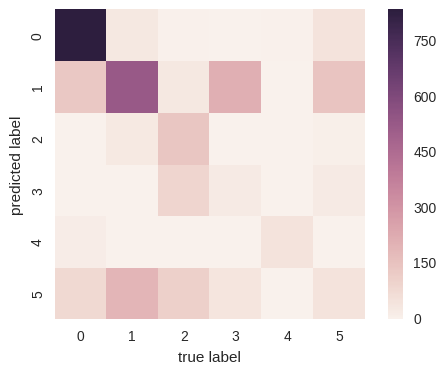

In [60]:
# Look at confusion matrix for some idea of accuracy. Meats has the highest rate of matching.

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(all_these.Label, predicted_labels)
sns.heatmap(mat.T, square=True)
plt.xlabel('true label')
plt.ylabel('predicted label')

# Predicted: 
# 0 is protein
# 1 is low everything
# 2 is high carb, low sugar
# 3 is high carb, high sugar
# 4 is high fat
# 5 is medium everything

# Ours:

# 0 is meat
# 1 is veggies
# 2 is cereal
# 3 is fruit
# 4 is oils
# 5 is dairy

In [61]:
all_these['guess'] = predicted_labels[0]
all_these['correct_guess'] = np.where((all_these.Label == all_these.guess), True, False)

In [62]:
def HowMatched3D(df, label_int, actual_label):
    """ Creates a 3D log log plot on the requested subplot.
    Arguments: 
    pred_cat = predicted dataframe for a category
    actual_cat = dataframe of the real category
    ax = plt axis instance
    actual_label = string with label for the actual category
    colors = list with two entries of strings for color names
    """
    ax = plt.subplot(projection='3d')
    TP = df[(df.Label == label_int)&(df.correct_guess==True)]
    FP = df[(df.guess == label_int)&(df.correct_guess==False)]
    FN = df[(df.Label == label_int)&(df.correct_guess==False)]
    print('Matches:',len(TP), 'In Group, is not '+actual_label+':',len(FP), 'Not in Group, is '+actual_label+':',len(FN))
    ax.scatter3D(np.log(TP.Protein),np.log(TP.Carbohydrate), np.log(TP.Fat), c = 'purple', label = 'In Group, is '+actual_label)
    ax.scatter3D(np.log(FP.Protein),np.log(FP.Carbohydrate), np.log(FP.Fat), c = 'crimson', label = 'In Group, is not '+actual_label)
    ax.scatter3D(np.log(FN.Protein),np.log(FN.Carbohydrate), np.log(FN.Fat), c = 'darkgreen', label = 'Not in Group, is '+actual_label)
    ax.view_init(elev=10, azim=45)
    
    ax.set_xlabel('Protein (log g)')
    ax.set_ylabel('Carbohydrate (log g)')
    ax.set_zlabel('Fat (log g)')
    plt.legend()

Matches: 837 In Group, is not Meat: 92 Not in Group, is Meat: 230


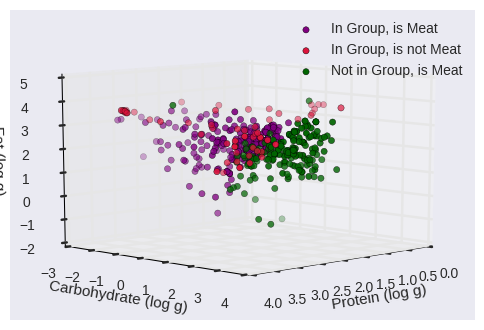

In [64]:
HowMatched3D(all_these, 0, 'Meat')

Matches: 529 In Group, is not Vegetable: 527 Not in Group, is Vegetable: 257


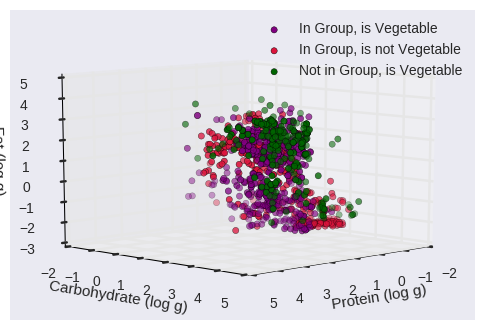

In [65]:
HowMatched3D(all_these, 1, 'Vegetable')

Matches: 142 In Group, is not Cereal: 37 Not in Group, is Cereal: 241


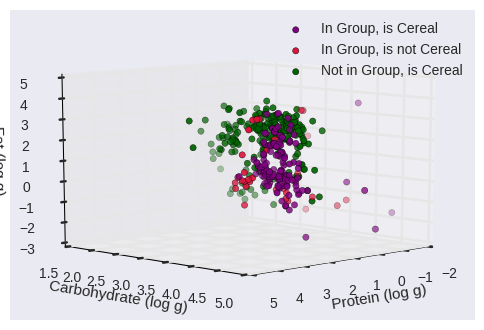

In [66]:
HowMatched3D(all_these, 2, 'Cereal')

Matches: 24 In Group, is not Fruit: 119 Not in Group, is Fruit: 256


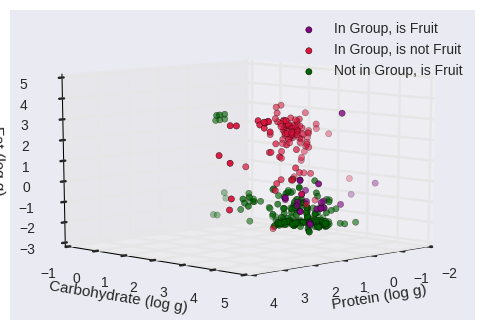

In [67]:
HowMatched3D(all_these, 3, 'Fruit')

Matches: 46 In Group, is not Oil: 19 Not in Group, is Oil: 7


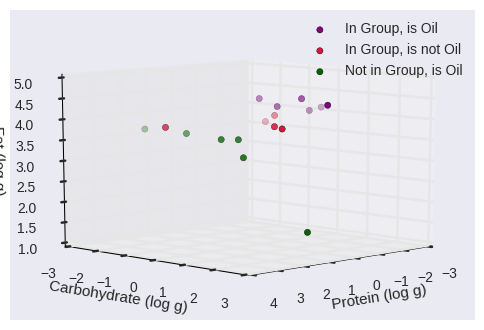

In [68]:
HowMatched3D(all_these, 4, 'Oil')

Matches: 52 In Group, is not Dairy: 428 Not in Group, is Dairy: 231


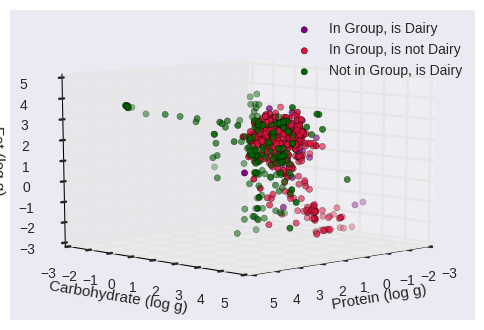

In [69]:
HowMatched3D(all_these, 5, 'Dairy')

In [70]:
all_these.groupby('guess').mean()

# 0 is protein
# 1 is low everything
# 2 is high carb, low sugar
# 3 is high carb, high sugar
# 4 is high fat
# 5 is medium everything

,Constant,Protein,Fat,Carbohydrate,Sugars,Label,correct_guess
guess,,,,,,,
0.0,8854.958785,21.264047,12.618945,1.659096,0.373950,0.340151,0.900969
1.0,11825.749049,3.268182,3.733617,7.092140,3.800379,1.861742,0.500947
2.0,6846.582192,10.049162,5.722346,64.426257,5.065363,2.005587,0.793296
3.0,9296.152542,6.644755,13.499301,59.844056,41.508392,2.636364,0.167832
4.0,6942.415094,2.796923,82.133846,0.655385,0.215385,3.076923,0.707692
5.0,12247.949602,6.333958,10.877917,25.503750,6.845417,1.668750,0.108333


In [71]:
def Examples(df, label_int, si = [0,5]):
    """ Creates a 3D log log plot on the requested subplot.
    Arguments: 
    pred_cat = predicted dataframe for a category
    actual_cat = dataframe of the real category
    ax = plt axis instance
    actual_label = string with label for the actual category
    colors = list with two entries of strings for color names
    """
    TP = df[(df.Label == label_int)&(df.correct_guess==True)]
    FP = df[(df.guess == label_int)&(df.correct_guess==False)]
    #FN = df[(df.Label == label_int)&(df.correct_guess==False)]
    print("Guessed Similar:")
    print(TP["Food Name"][si[0]:si[1]])
    print("\nSurprising:")
    print(FP["Food Name"][si[0]:si[1]])

In [73]:
print('High Protein Group')
Examples(all_these, 0)
print('\nLow Everything Group')
Examples(all_these, 1)

High Protein Group
Guessed Similar:
607    Shrimps, boiled
610    Lobster, boiled
611       Crab, boiled
612     Shrimps, dried
613    Shrimps, frozen
Name: Food Name, dtype: object

Surprising:
162    Cheese sandwich biscuits
165                Krackerwheat
347        Soya flour, full fat
348         Soya flour, low fat
361                   Wheatgerm
Name: Food Name, dtype: object

Low Everything Group
Guessed Similar:
2638    Pigeon peas, dahl, dried, boiled in unsalted w...
2641                          Pinto beans, re-fried beans
2642    Red kidney beans, dried, boiled in unsalted water
2647                                     Papri beans, raw
2649    Mung beans, whole, dried, boiled in unsalted w...
Name: Food Name, dtype: object

Surprising:
158                                Cornish wafers
163                                     Fig rolls
164                                Fruit biscuits
166    Oat based biscuits, chocolate, half coated
173             Shortcake, chocolate, hal

In [75]:
print('High Carb, Low Sugar Group')
Examples(all_these, 2)
print('\nHigh Carb, High Sugar Group')
Examples(all_these, 3)

High Carb, Low Sugar Group
Guessed Similar:
141             Shortbread
143    Semi-sweet biscuits
145     Oatcakes, homemade
147       Oatcakes, retail
150     Wholemeal crackers
Name: Food Name, dtype: object

Surprising:
1034                           Tamarind
2637      Pigeon peas, dahl, dried, raw
2639            Pinto beans, dried, raw
2644    Lentils, red, split, dried, raw
2645       Red kidney beans, dried, raw
Name: Food Name, dtype: object

High Carb, High Sugar Group
Guessed Similar:
924    Grapefruit juice concentrate, unsweetened
925                      Grape juice concentrate
933                                 Pears, dried
960                             Pineapple, dried
972                                   Mixed peel
Name: Food Name, dtype: object

Surprising:
140    Biscuits, homemade, rubbing-in method
142            Crunch biscuits, cream filled
144          Sandwich biscuits, cream filled
146                     Short sweet biscuits
148                   Wafer bis

In [76]:
print('High Fat Group')
Examples(all_these, 4)
print('\nMid Everything Group')
Examples(all_these, 5)

High Fat Group
Guessed Similar:
554                      Butteroil, unsalted
555                               Ghee, palm
556    Compound cooking fat, polyunsaturated
557                 Cocoa butter alternative
558                             Cocoa butter
Name: Food Name, dtype: object

Surprising:
3301                             Tomatoes, sun dried
2058                                   Cheese, cream
2107                           Cream, fresh, clotted
2111    Cream, fresh, double, including Jersey cream
700                                     Taramasalata
Name: Food Name, dtype: object

Mid Everything Group
Guessed Similar:
2115      Lollies, containing ice-cream
2116    Ice cream bar, chocolate coated
2117          Ice cream, dairy, premium
2118                      Sorbet, fruit
2119               Chocolate nut sundae
Name: Food Name, dtype: object

Surprising:
180    White bread, fried in lard
186               Wheatgerm bread
188      Wholemeal bread, average
195           Papp

In [25]:
# 1518 correct guesses, some examples of which follow
guessed_correctly = all_these[all_these.correct_guess == True]
print(guessed_correctly['Food Name'])

140                 Biscuits, homemade, rubbing-in method
141                                            Shortbread
142                         Crunch biscuits, cream filled
143                                   Semi-sweet biscuits
144                       Sandwich biscuits, cream filled
145                                    Oatcakes, homemade
146                                  Short sweet biscuits
147                                      Oatcakes, retail
148                                Wafer biscuits, filled
149                                             Flapjacks
150                                    Wholemeal crackers
151                          Gingernut biscuits, homemade
152                   Biscuits, homemade, creaming method
153                         Biscuits, homemade, wholemeal
154                   Biscuits, melting moments, homemade
155                                    Oat based biscuits
156         Chocolate biscuits, cream filled, full coated
157           

In [26]:
# 1334 incorrect guesses. Some examples follow.

guessed_wrong = all_these[all_these.correct_guess==False]
print(guessed_wrong['Food Name'])

158                                        Cornish wafers
162                              Cheese sandwich biscuits
163                                             Fig rolls
164                                        Fruit biscuits
165                                          Krackerwheat
166            Oat based biscuits, chocolate, half coated
173                     Shortcake, chocolate, half coated
177                       White bread, 'with added fibre'
179     White bread, farmhouse or split tin, freshly b...
181                                   White bread, sliced
182                             White bread, Danish style
184                                  White bread, premium
186                                       Wheatgerm bread
188                              Wholemeal bread, average
195                                   Pappadums, takeaway
197                                               Paratha
201                                             Rye bread
203           

Beyond this point are pairs of 3D cluster plots, to compare each generated group with the food pyramid groups.

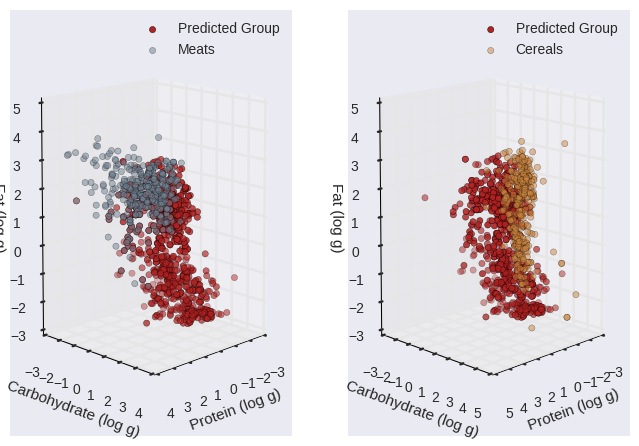

In [27]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled0, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled0, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

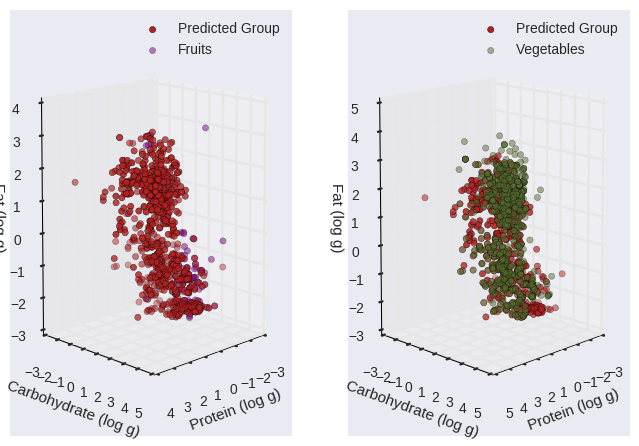

In [28]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled0, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled0, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

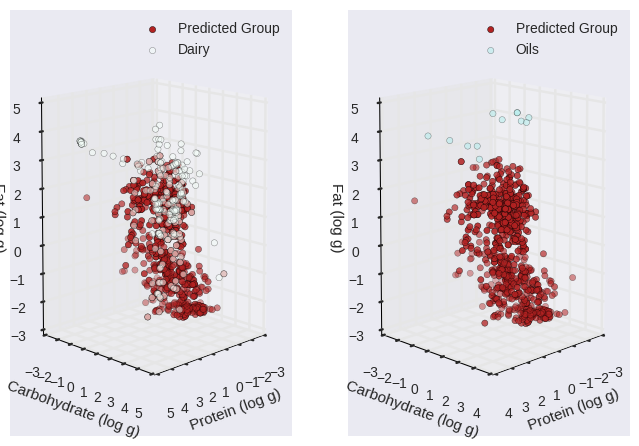

In [29]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled0, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled0, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

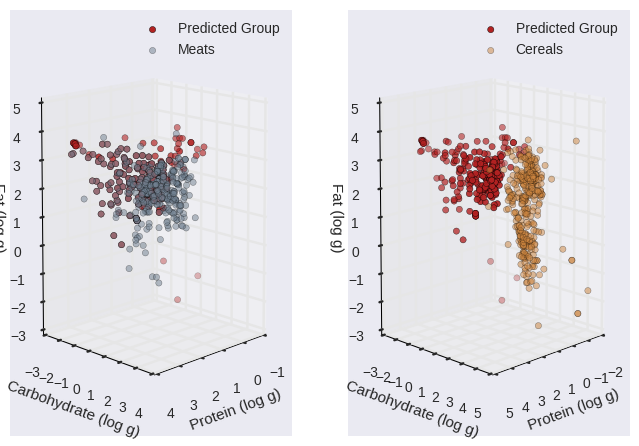

In [30]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled1, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled1, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

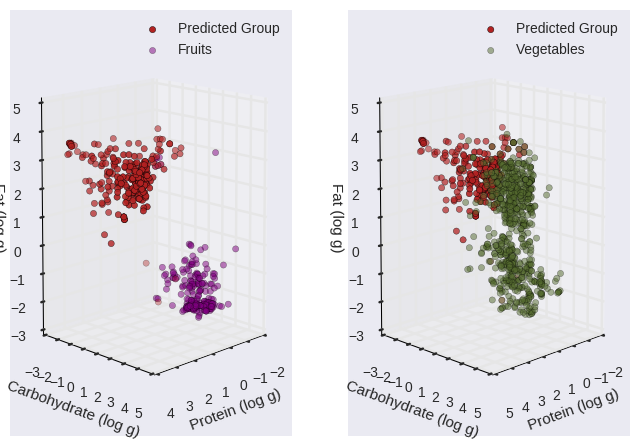

In [31]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled1, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled1, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

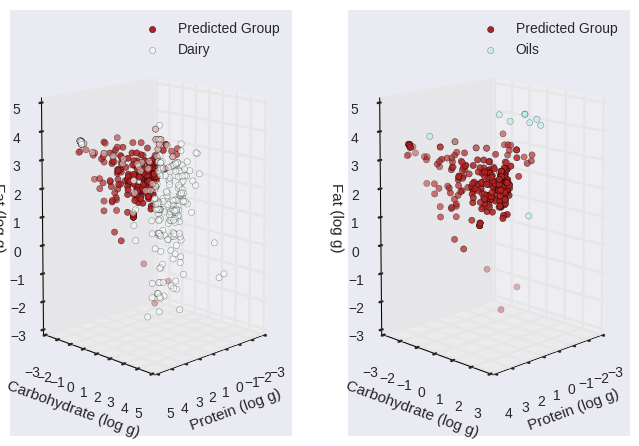

In [32]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled1, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled1, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

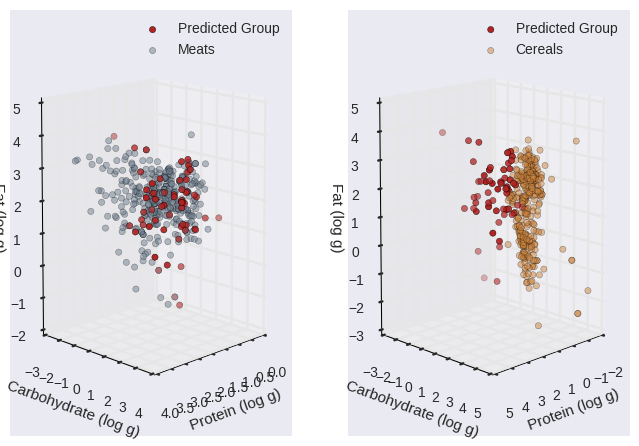

In [33]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled2, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled2, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

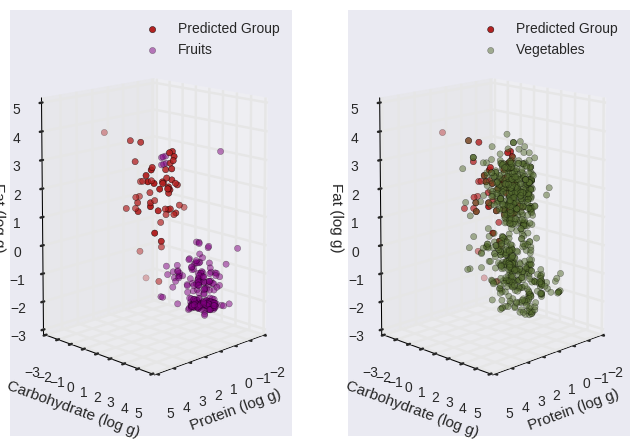

In [34]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled2, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled2, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

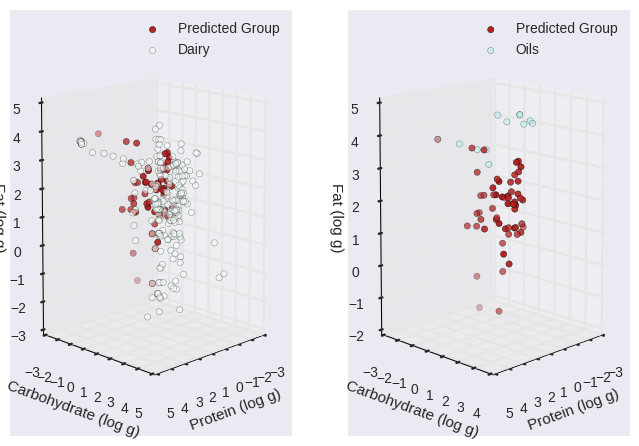

In [35]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled2, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled2, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

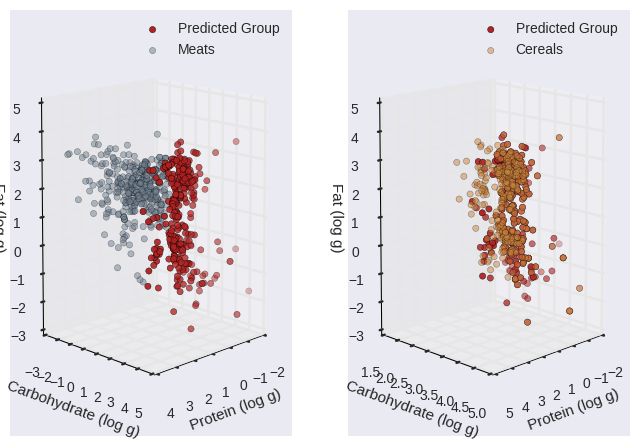

In [36]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled3, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled3, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

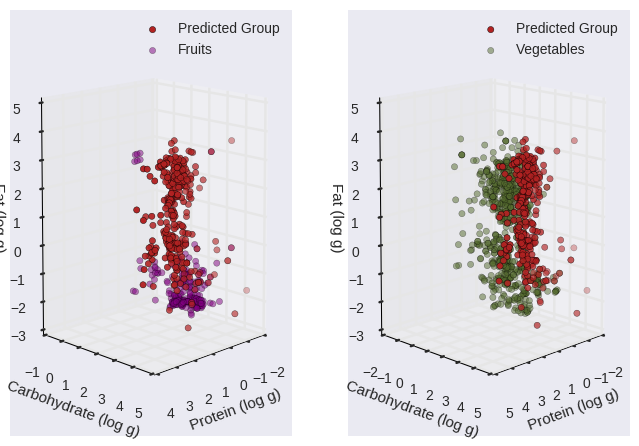

In [37]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled3, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled3, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

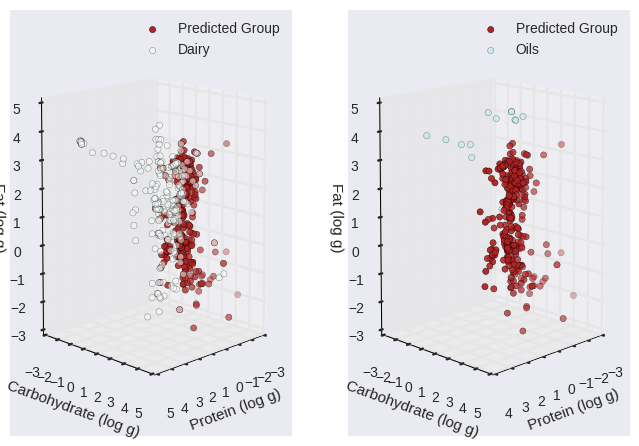

In [38]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled3, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled3, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

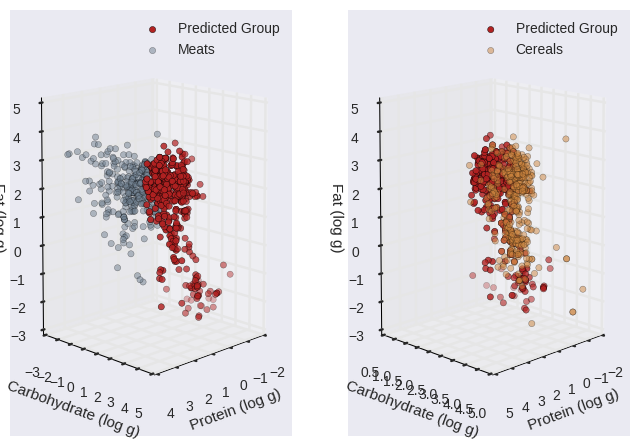

In [39]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled4, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled4, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

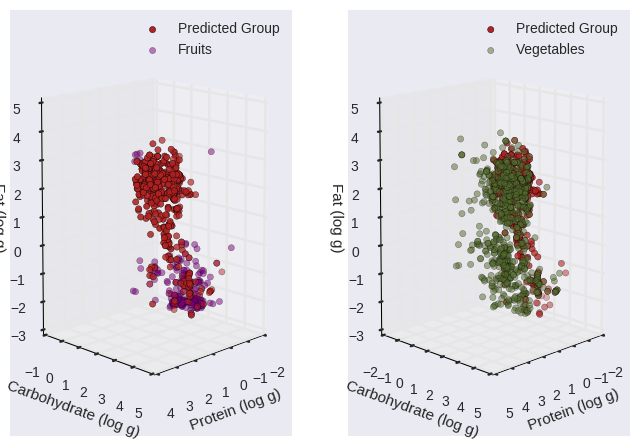

In [40]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled4, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled4, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

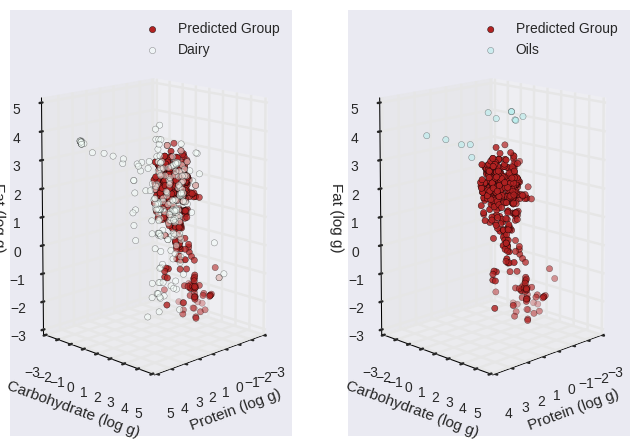

In [41]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled4, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled4, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

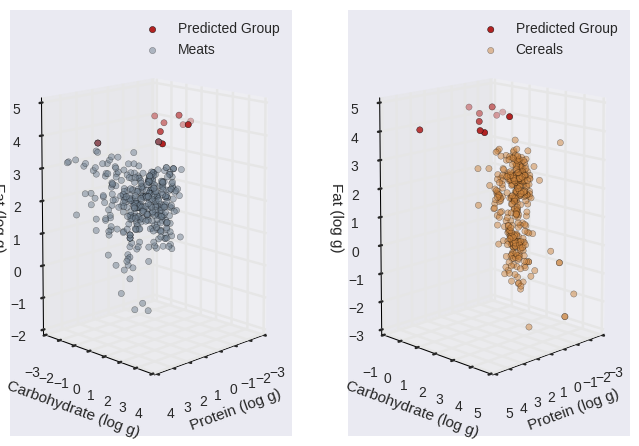

In [42]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled5, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled5, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

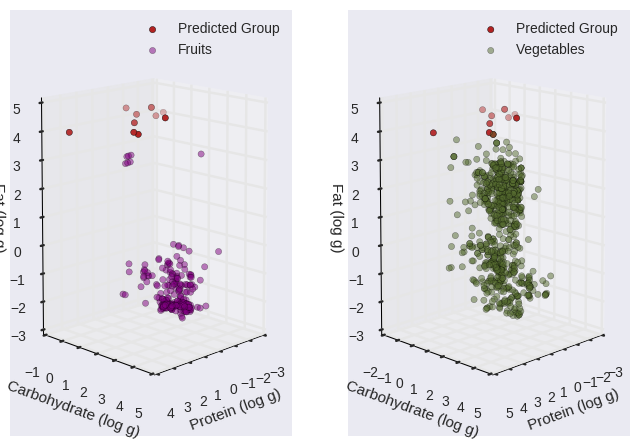

In [43]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled5, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled5, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

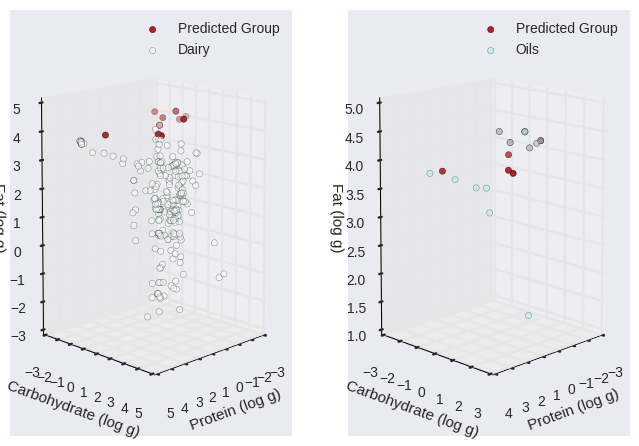

In [44]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled5, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled5, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()